<center>
<img src="img/ml_theme.png">
# Вводный курс по нейронным сетям
<center>
**Автор материала: программист-исследователь Mail.Ru Group  Юрий Кашницкий**

# <center>Часть 3. Алгоритм Backpropagation (продолжение), основы библиотеки PyTorch
<center>Данный материал создан на базе [лекций](https://habrahabr.ru/company/mailru/blog/344982/) "Техносферы", подробной [статьи](https://habrahabr.ru/post/334380/) на Хабрахабре по PyTorch и [документации](http://pytorch.org/docs/0.3.0/)

## План
1. Простая нейронная сеть на NumPy
2. Тензоры и операции над ними
3. Простая нейронная сеть на PyTorch (ручное дифференцирование)
4. Автоматическое дифференцирование
5. Простая нейронная сеть на PyTorch (автоматическое дифференцирование)
6. Загрузка и подготовка данных
7. Softmax-классификатор с MNIST
8. Сохранение и загрузка модели

## 1. Простая нейронная сеть на NumPy

In [1]:
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
%matplotlib inline

Рассмотрим задачу регрессии, но не настолько стандартную, как в случае двух векторов и МНК. На входе матрица $X$ размерности $N \times D$ со случайными значениями из нормального распределения, на выходе – матрица $Y$ размерности $N \times C$, тоже со случайными значениями из нормального распределения. Будем обучать нейронную сеть с одним скрытым слоем, пусть в нем $H$ нейронов. Метрика – среднеквадратичная ошибка. Сеть должна восстановить значения $Y$ по входу $X$. И ничего страшного, что сейчас мы будем переобучаться. 

<img src='img/hw3_net.png'>

*Разбор графа вычислений и backprop у доски. В помощь: ["Backpropagation for a Linear Layer"](http://cs231n.stanford.edu/handouts/linear-backprop.pdf).*

In [2]:
# N - размер батча; D_in - размерность входа;
# H - скрытая размерность; D_out размерность выхода.
N, D, H, C = 64, 1000, 100, 10

# инициализируем вход и выход из нормального распределения
x = np.random.randn(N, D)
y = np.random.randn(N, C)

# Инициализируем веса из нормального распределения
w1 = np.random.randn(D, H)
w2 = np.random.randn(H, C)

# будем запоминать значения функции потерь по 100 итерациям
loss_by_iter = []
num_epochs = 100
learning_rate = 1e-6

for t in tqdm_notebook(range(num_epochs)):

    # активация в скрытом слое перед нелинейностью
    h = x.dot(w1)
    
    # Используем функцию активации ReLU
    # Получаем активацию в скрытом слое после применения нелинейности
    h_relu = np.maximum(h, 0)
    
    # Выход
    y_pred = h_relu.dot(w2)

    # Считаем функцию потерь, запоминаем ее
    loss = np.square(y_pred - y).sum()
    loss_by_iter.append(loss)

    # Считаем градиенты (backprop)
    grad_y_pred = 2 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h < 0] = 0
    grad_w1 = x.T.dot(grad_h)

    # Обновляем веса
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2 

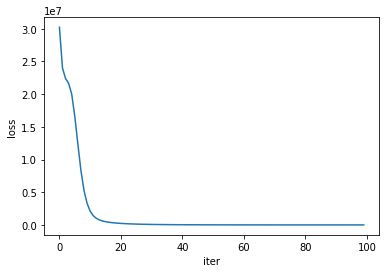

In [3]:
plt.plot(range(num_epochs), loss_by_iter);
plt.xlabel('iter')
plt.ylabel('loss');

Тут произошло немало матричных умножений, а конкретно, 500. В большой нейронной сети счет пойдет на миллиарды, и эффективней делать это распределенно и на GPU. PyTorch создан как раз для этого: чтоб писать код было почти так же приятно, как на NumPy, только производные еще сами будут считаться (автоматическое дифференцирование, AD), а вычисления будут происходить на GPU. Если упрощать, то 
<br><br>
<center>**PyTorch = NumPy + CUDA + AD**</center>

Но сначала надо научиться работать с тензорами. Ничего общего с математическим определением тензора как полилинейного оператора, тут все проще: тензор – это по сути тот же многомерный массивы `NumPy`, только с ним можно работать на GPU.

## 2. Тензоры и операции над ними

В интерфейсе базовых операций тензор ничем не отличается от `np.array`, но при этом тензоры можно эффективно использовать при обучении на GPU. 

In [4]:
import torch

 Другие возможные типы:

In [6]:
torch.HalfTensor;      # 16 бит, с плавающей точкой
torch.FloatTensor;     # 32 бита,  с плавающей точкой
torch.DoubleTensor;    # 64 бита, с плавающей точкой

torch.ShortTensor;     # 16 бит, целочисленный, знаковый
torch.IntTensor;       # 32 бита, целочисленный, знаковый
torch.LongTensor;      # 64 бита, целочисленный, знаковый

torch.CharTensor;      # 8 бит, целочисленный, знаковый
torch.ByteTensor;      # 8 бит, целочисленный, беззнаковый

Тензор, инициализированный значениями из равномерного распределения.

In [7]:
x = torch.rand(5, 3)
x

tensor([[ 0.8520,  0.9648,  0.9146],
        [ 0.2606,  0.9351,  0.5818],
        [ 0.0226,  0.1164,  0.1932],
        [ 0.1460,  0.7345,  0.4539],
        [ 0.3634,  0.0839,  0.1272]])

А вот, к примеру, `ByteTensor` размерности $3 \times 4$. Кто-то тут уже даже видит картинку. 

In [8]:
a = torch.ByteTensor(3, 4).random_()
a

tensor([[  84,  101,   39,  151],
        [  64,   12,   53,   85],
        [ 134,    4,  255,   89]], dtype=torch.uint8)

In [9]:
x.size()

torch.Size([5, 3])

Сложение тензоров

In [10]:
y = torch.rand(5, 3)
y

tensor([[ 0.1780,  0.6796,  0.0114],
        [ 0.7583,  0.7170,  0.3849],
        [ 0.1423,  0.7807,  0.9958],
        [ 0.4177,  0.0790,  0.0106],
        [ 0.4029,  0.8197,  0.6498]])

Первый вариант

In [11]:
x + y

tensor([[ 1.0300,  1.6444,  0.9260],
        [ 1.0190,  1.6522,  0.9667],
        [ 0.1649,  0.8971,  1.1890],
        [ 0.5637,  0.8135,  0.4645],
        [ 0.7663,  0.9036,  0.7770]])

Второй вариант

In [12]:
x.add(y)

tensor([[ 1.0300,  1.6444,  0.9260],
        [ 1.0190,  1.6522,  0.9667],
        [ 0.1649,  0.8971,  1.1890],
        [ 0.5637,  0.8135,  0.4645],
        [ 0.7663,  0.9036,  0.7770]])

Третий вариант

In [13]:
torch.add(x, y)

tensor([[ 1.0300,  1.6444,  0.9260],
        [ 1.0190,  1.6522,  0.9667],
        [ 0.1649,  0.8971,  1.1890],
        [ 0.5637,  0.8135,  0.4645],
        [ 0.7663,  0.9036,  0.7770]])

Выход можно сохранить в другую переменную

In [14]:
result = torch.Tensor(5, 3)
torch.add(x, y, out=result)

tensor([[ 1.0300,  1.6444,  0.9260],
        [ 1.0190,  1.6522,  0.9667],
        [ 0.1649,  0.8971,  1.1890],
        [ 0.5637,  0.8135,  0.4645],
        [ 0.7663,  0.9036,  0.7770]])

Перевод из numpy в torch

In [15]:
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
print(a)
print(b) 

[ 2.  2.  2.  2.  2.]
tensor([ 2.,  2.,  2.,  2.,  2.], dtype=torch.float64)


Матричное умножение тензоров

In [16]:
a = torch.randn(5, 3) 
b = torch.randn(3, 4)

In [17]:
torch.mm(a,b)
a.mm(b)

tensor([[-0.5300,  2.0902, -1.3401,  0.8438],
        [-1.4397, -1.5000,  1.6658,  2.2095],
        [ 1.0143, -1.8657,  0.6975, -0.7985],
        [-0.6684,  1.1371,  0.6792, -2.4056],
        [-2.4721,  1.0150,  1.4781,  0.3531]])

В Python 3 можно просто так:

In [18]:
a @ b

tensor([[-0.5300,  2.0902, -1.3401,  0.8438],
        [-1.4397, -1.5000,  1.6658,  2.2095],
        [ 1.0143, -1.8657,  0.6975, -0.7985],
        [-0.6684,  1.1371,  0.6792, -2.4056],
        [-2.4721,  1.0150,  1.4781,  0.3531]])

Подробней про тензоры и в целом про PyTorch – в этой классной [статье](https://habrahabr.ru/post/334380/) на Хабре.

## 3. Простая нейронная сеть на PyTorch (ручное дифференцирование)

Пока что отличия от первой `NumPy`-версии выглядят почти что косметическими. Но уже один важный момент: если изменить тип тензоров `dtype`, то данные могут обрабатываться на GPU, если она настроена.

In [19]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # GPU

N, D_in, H, D_out = 64, 1000, 100, 10

x = torch.randn(N, D_in).type(dtype)
y = torch.randn(N, D_out).type(dtype)

w1 = torch.randn(D_in, H).type(dtype)
w2 = torch.randn(H, D_out).type(dtype)

# будем запоминать значения функции потерь по 100 итерациям
loss_by_iter = []
num_epochs = 100
learning_rate = 1e-6
for t in tqdm_notebook(range(num_epochs)):

    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    loss = (y_pred - y).pow(2).sum()
    loss_by_iter.append(loss)

    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

Widget Javascript not detected.  It may not be installed or enabled properly.


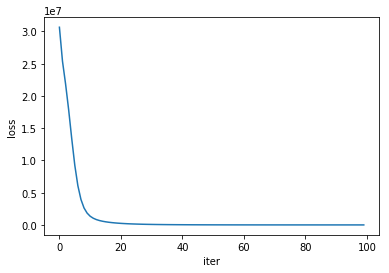

In [20]:
plt.plot(range(num_epochs), loss_by_iter);
plt.xlabel('iter')
plt.ylabel('loss');

## 4. Автоматическое дифференцирование 

Начиная с версии 0.4.0 объект `tensor` хранит сам тензор, его градиент и указатель, который позволяет поместить тензор в граф вычислений. В прежних версиях это было в `torch.autograd.Variable`, где `Variable` можно было рассматривать как обертку вокруг тензора.
Через аргумент `data` передаются данные. Аргумент `requires_grad` – нужно ли для этой переменной вычислять градиент. Скажем, для входа $X$ и выхода $Y$ не надо, поскольку их мы менять не собираемся.

После окончания вычислений можно просто запустить `.backward()`, и все нужные градиенты будут посчитаны. 

![](https://habrastorage.org/webt/p0/vm/q7/p0vmq74amxsgztephnluw_woan8.jpeg)

По мере вычисления строится граф, в котором каждый узел – это `tensor` (в прежних версиях PyTorch – `torch.autograd.Variable`).
У каждой переменной есть `.grad_fn`, где хранится производная функции (класс `Function`), породившей эту переменную. 


Покажем на примере:

$X = \begin{bmatrix} 1 & 1 \\ 1 & 1\end{bmatrix}$, $Z = 2 * (X + 2) ^ 2$, $out = \bar{Z}$


In [21]:
x = torch.ones(2, 2, requires_grad=True)
x  

tensor([[ 1.,  1.],
        [ 1.,  1.]])

In [22]:
x.data

tensor([[ 1.,  1.],
        [ 1.,  1.]])

In [23]:
x.grad

In [24]:
# производная операции, которая породила переменную, пока пусто
x.grad_fn

In [25]:
y = x + 2
y

tensor([[ 3.,  3.],
        [ 3.,  3.]])

Переменная $y$ была порождена в процессе вычисления некоторой функции. У этой функции есть производная, поэтому `y.grad_fn` уже не пуст.

In [26]:
y.grad_fn

In [27]:
z = y * y * 2
z

tensor([[ 18.,  18.],
        [ 18.,  18.]])

In [28]:
out = z.mean()
out

tensor(18.)

Запускаем бэкпроп

In [29]:
out.backward()

In [30]:
x.grad

tensor([[ 3.,  3.],
        [ 3.,  3.]])

И дальше, в общем-то, можно творить что угодно. PyTorch будет запоминать все вычисления, строить их граф и будет знать, как посчитать се градиенты.

In [31]:
v = torch.randn(3, requires_grad=True)

w = v * 2
while w.data.norm() < 1000:
    w = w * 2

print(w)

tensor([ 1207.6654,   615.0544,   467.4764])


In [32]:
gradients = torch.FloatTensor([0.1, 1.0, 0.0001])
w.backward(gradients)

print(v.grad)

tensor([  51.2000,  512.0000,    0.0512])


А вот как можно написать свой вычислительный блок – вершину графа вычислений. Надо наследоваться от `torch.autograd.Function` и реализовать прямой и обратный проходы - методы `forward` и `backward`. 

- метод `forward` принимает вход, производит с ним необходимые вычисления и сохраняет вход, чтоб потом посчитать градиент приобратном проходе
- метод `backward` принимает градиент, распаковывает сохраненные ранее (при прямом проходе) переменные и вычисляет градиент, который надо будет далее распространить по графу вычислений

И так, в общем-то, все это работает для сколь угодно сложных слоев. Вот пример с ReLU:

In [33]:
class MyReLU(torch.autograd.Function):

    def forward(self, inp):
        self.save_for_backward(inp)
        return inp.clamp(min=0)

    def backward(self, grad_out):
        inp, = self.saved_tensors
        grad_inp = grad_out.clone()
        grad_inp[inp < 0] = 0
        return grad_inp

Если мы хотим сохранить значения переменных в графе, то используем `retain_graph` = True. 
Это может быть нужно, если мы хотим несколько раз подряд сделать backprop.

In [34]:
x = torch.ones(2, 2, requires_grad = True)
y = x + 2
y.backward(torch.ones(2, 2))
x.grad

tensor([[ 1.,  1.],
        [ 1.,  1.]])

In [35]:
gradient = torch.randn(2, 2)

y.backward(gradient)

x.grad

tensor([[ 0.3550,  0.0180],
        [-0.6153,  1.7628]])

## 5. Простая нейронная сеть на PyTorch (автоматическое дифференцирование)

Вот теперь уже действительно включается вся мощь фреймворков глубокого обучения. Не вручную с карандашом и листиком, в очках, выписываем производные, а считаем их автоматически.

In [36]:
N, D_in, D_out = 64, 1000, 10

# переменные x и у, их менять не будем
x = torch.randn(N, D_in) #, requires_grad=False)
y = torch.randn(N, D_out) #, requires_grad=False)

# Модель – линейная, добавили просто линейный слой
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_out))

loss_fn = torch.nn.MSELoss(size_average=False)

# будем запоминать значения функции потерь по 100 итерациям
loss_by_iter = []
num_epochs = 100
learning_rate = 1e-4
for t in tqdm_notebook(range(num_epochs)):
    
    # прямой проход
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss_by_iter.append(loss.data.item())

    # обратный проход
    loss.backward()

    # обновление весов
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data
    
    # Вручную зануляем градиенты после обновления весов
    model.zero_grad()

Widget Javascript not detected.  It may not be installed or enabled properly.


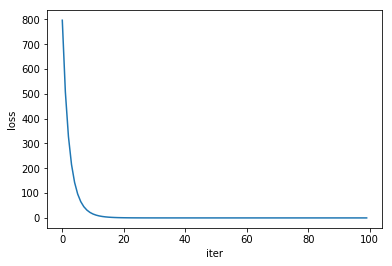

In [37]:
plt.plot(range(num_epochs), loss_by_iter);
plt.xlabel('iter')
plt.ylabel('loss');

In [38]:
loss_fn(model(x), y)

tensor(1.00000e-10 *
       6.3265)

Теперь то же самое, только градиентный спуск не руками пишем, а используем готовый оптимизатор, например Adam. Обсуждение различных оптимизаторов, как и прочих трюков обучения нейронных сетей – тема 4 лекции.

In [39]:
N, D_in, D_out = 64, 1000, 10

x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_out))

# с `size_average=False` потери суммируются по всем батчам, то есть деления на размер батча не происходит
loss_fn = torch.nn.MSELoss(size_average=False)

# будем запоминать значения функции потерь по 100 итерациям
loss_by_iter = []
num_epochs = 200
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in tqdm_notebook(range(num_epochs)):
    
    # прямой проход
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss_by_iter.append(loss.data.item())

    # обратный проход
    loss.backward()
    
    # шаг обновления весов
    optimizer.step()
    
    # вручную зануляем градиенты после обновления весов
    optimizer.zero_grad()

Widget Javascript not detected.  It may not be installed or enabled properly.


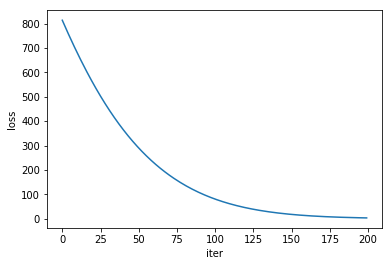

In [40]:
plt.plot(range(num_epochs), loss_by_iter);
plt.xlabel('iter')
plt.ylabel('loss');

## 6. Загрузка и подготовка данных

В `PyTorch` очень удобные классы для загрузка и подготовка данных:
Основные классы `torch.utils.data`
- `Dataset` – загрузка данных, предобработка, аугментация
- `DataLoader` – разбиение на батчи, перемешивание объектов и балансировка классов

In [41]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.nn as nn

mnist_mean, mnist_std = 0.1307, 0.3081 # заранее посчитаны

transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_std,))
                    ])
train_dataset = MNIST('data/mnist/', train=True, download=False, transform=transform)
test_dataset = MNIST('data/mnist/', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## 7. Softmax-классификатор с MNIST

Определям прямой проход для сети. С обратным `PyTorch` как раз сам разберется, поскольку мы задействуем слой `nn.Linear`, а для него обратный проход уже реализован.

In [42]:
class MySoftmax(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MySoftmax, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

Задаем константы, в том числе гиперпараметры обучения

In [43]:
input_size, num_classes = 784, 10
num_epochs, batch_size, learning_rate = 5, 128, 1e-3

Создаем модель и указываем фукцию потерь и оптимизатор. `CrossEntropyLoss` как раз будет считать Softmax.

In [44]:
model = MySoftmax(input_size, num_classes)

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

Обучаем модель.

In [45]:
loss_by_iter = []
for epoch in tqdm_notebook(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        # images.view преобразует тензор так, чтоб второе измерение было длины 28 * 28=784
        images = images.view(-1, 28 * 28)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_by_iter.append(loss.data.item())
        loss.backward()
        optimizer.step()

Widget Javascript not detected.  It may not be installed or enabled properly.


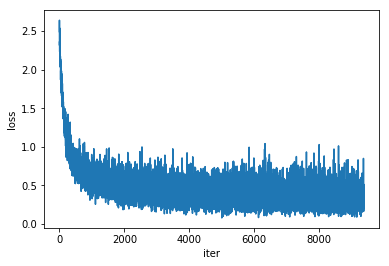

In [46]:
plt.plot(range(len(loss_by_iter)), loss_by_iter);
plt.xlabel('iter')
plt.ylabel('loss');

Проверяем модель на тестовых данных.

In [47]:
correct, total = 0, 0
for images, labels in test_loader:
    images = images.view(-1, 28 * 28)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy of the model on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the model on the 10000 test images: 90 %


Качество довольно скромное. Не хватает настройки гиперпараметров. А заметное улучшение качества будет достигаться за счет других моделей – сверточных нейронных сетей (5-ая лекция).

## 8. Сохранение и загрузка модели

К этому моменту мы уже провели какие-то вычисления, это заняло около минуты. Большие нейронные сети могут обучаться неделями, месяцами и даже вплоть до года в случае ImageNet. Поэтому полезно уметь сохранить веса сети вместе с ее состоянием (оптимизатор, номер эпохи, размер батча и т.д.), чтоб потом "достать" для применения (прогнозов) или дообучения.

In [48]:
def save_checkpoint(state, filename='checkpoint.tar'):
    torch.save(state, filename)
    
epoch = 10   
save_checkpoint({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict()
})

Пример загрузки модели из файла

In [49]:
checkpoint = torch.load('checkpoint.tar')
start_epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])